In [79]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import scipy
import scipy.integrate as integrate
import numpy.linalg as linalg
from multipledispatch import dispatch

In [105]:
#must be greater than 0
au2nm=0.05291
au2ev=27.211

adaptive=False
startR=-0.1/au2nm
endR=0.1/au2nm
N=10
sites=N+1
a=0.05291*0.5/au2nm
deltaX=np.abs(startR-endR)/(N)
eps=0.5968404*au2nm*au2ev
n=1
sigma=1
valueAtZero=1/(2*np.pi*a*eps)

In [81]:
def electronDensity(r, a):
    return (1/(np.pi*a**3))*(np.exp(-2*r/a)) if r>0 else (1/(np.pi*a**3))*(np.exp(2*r/a))

@dispatch(float, float)
def linearFunction(r, n):
    return 1/(deltaX) *(r-n)+1 if r<n else -1/(deltaX) *(r-n)+1

#n is the middle
#a_1 is the left most
#a_2 is the right most
@dispatch(float, float, float, float)
def linearFunction(r, a_1, n, a_2):
    return 1/(n-a_1) *(r-n)+1 if r<n else -1/(a_2-n) *(r-n)+1

def integrand(r, eps, n, edensity):
    return ((1/eps)*edensity(r,a)*linearFunction(r, n)*r**2)

def integrandAdaptive(r, eps, n, edensity, a_1, a_2):
    return (1/eps)*edensity(r,a)*linearFunction(r, a_1, n, a_2)*r**2

def getIntegral(a_1, a_2, eps, n, edensity):
    return integrate.quad(integrand, a_1, a_2, args=(eps, n, edensity))[0]

def getIntegralAdaptive(a_1, a_2, eps, n, edensity):
    return integrate.quad(integrandAdaptive, a_1, a_2, args=(eps, n, edensity, a_1, a_2))[0]

def gaussianElectronDensity(r, sigma):
    return (1/np.sqrt(2*np.pi*sigma**2))**3*(np.exp((-r**2)/(2*sigma**2)))

def electronDensity_2s(r, a):
    return -(1/(32*np.pi*a**3))*(2-r/a)*np.exp(-r/a) if r>0 else -(1/(32*np.pi*a**3))*(2+r/a)*np.exp(r/a)

def v_gauss(r):
    return 1/(4*np.pi*eps)*(1/r)*scipy.special.erf(r/np.sqrt(2*a**2))

def v(r):
    return (1/(4*np.pi*eps*a**2))*(a**2/r-(a**2/r-a)*np.exp(-2*r/a)) if r>0 else (1/(4*np.pi*eps*a**2))*(-a**2/r-(-a**2/r-a)*np.exp(2*r/a))

def v_2s(r):
    return -(1/(32*np.pi*eps))*(8/r-(8/r+2/a-2*r/(a**2)-r**2/a**3)*np.exp(-r/a)) if r>0 else (1/(32*np.pi*eps))*(-8/r-(-8/r+2/a+2*r/(a**2)-r**2/a**3)*np.exp(r/a))

In [82]:
#func gives grid size at each point
def generateUniformGrid(N):
    delX=(endR-startR)/N
    return [(startR+i*delX,startR+(i+1)*delX) for i in range(N)]

def riemannEst(a_1, a_2, func):
    return func((a_2-a_1)/2+a_1,a)*(a_2-a_1)

def adaptivelySubdivide(l, func, eps,n,maxIt):
    absError=np.abs(riemannEst(l[0], l[1], func)-(riemannEst(l[0], (l[1]-l[0])/2+l[0], func)+riemannEst((l[1]-l[0])/2+l[0], l[1],func)))
    relError=np.abs(absError/(riemannEst(l[0], l[1], func)))
    if(relError<eps or n>maxIt):
        return np.array([l])
    else:
        left=(l[0], (l[1]-l[0])/2+l[0])
        right=((l[1]-l[0])/2+l[0], l[1])
        temp=(np.concatenate((adaptivelySubdivide(left, func, eps, n+1,maxIt),adaptivelySubdivide(right, func, eps,n+1,maxIt))))
        return temp
    
#adaptively subdivided to func
def generateListOfAdaptiveGridCoords(N, func, eps, maxIt):
    uni=generateUniformGrid(N)
    newList=[];
    for i in range(len(uni)):
        #adaptively subdivide returns a list
        temp=adaptivelySubdivide(uni[i], func, eps, 0, maxIt);
        for x in temp:
            newList.append(x)
    return np.array(newList,dtype=object)

In [83]:
#uniform
def constructResultVector(eDensity):
    theList=[getIntegral(startR+(i-1)*deltaX, startR+(i+1)*deltaX, eps, startR+i*deltaX,eDensity) for i in range(1,sites-1)];
    return np.array(theList);

def createListOfMidCoord(temp):
    return np.array((x[1]-x[0])/2+x[0] for x in temp)

def createListOfIntervals(adpGrid):
    return np.array([np.abs(x[1]-x[0]) for x in adpGrid])

#getIntegralAdaptive(a_1, a_2, eps, n, edensity)
def constructResultVectorAdaptive(adpGrid, eDensity):
    theList=[getIntegralAdaptive(adpGrid[i-1][0], adpGrid[i+1][0] if i+1<np.shape(adpGrid)[0] else adpGrid[i][1]+deltaX, eps, adpGrid[i][0], eDensity) for i in range(1, np.shape(adpGrid)[0])];
    return np.array(theList);

@dispatch(int)
def mk(i):
    return ((startR+deltaX*i)**3-(startR+deltaX*(i-1))**3)/(3*deltaX**2)

@dispatch(int, np.ndarray)
def mk(i, adpGrid):
    one=adpGrid[i][0] if i<np.shape(adpGrid)[0] else adpGrid[np.shape(adpGrid)[0]-1][1]
    return (one**3-(adpGrid[i-1][0])**3)/(3*(adpGrid[i-1][1]-adpGrid[i-1][0])*(adpGrid[i][1]-adpGrid[i][0]))

In [84]:
def boundary_condition(r):
    if(0<=r and r<endR/2):
        return valueAtZero
    return (1/(4*np.pi*eps))*1/np.abs(r)

def addBoundaryConditions(b):
    b[0]+=boundary_condition(startR)*mk(1)
    b[b.size-1]+=boundary_condition(endR)*mk(N)
    return b

In [85]:
def constructMatrix():
    temp=np.zeros((sites, sites));
    for i in range(sites-1):
        if(i>0):
            temp[i, i-1]=-mk(i)
        if(i>=0):
            temp[i, i]=mk(i+1)+mk(i)
        if(i+1<sites):
            temp[i, i+1]=-mk(i+1)
    temp=np.delete(temp, [0, sites-1], axis=1)
    temp=np.delete(temp, [0, sites-1], axis=0)
    return temp

def constructMatrixAdp(adGrid):
    temp=np.zeros((np.shape(adpGrid)[0]+1, np.shape(adpGrid)[0]+1));
    for i in range(sites-1):
        if(i>0):
            temp[i, i-1]=-mk(i, adpGrid)
        if(i>=0):
            temp[i, i]=mk(i+1,adpGrid)+mk(i,adpGrid)
        if(i+1<sites):
            temp[i, i+1]=-mk(i+1,adpGrid)
    temp=np.delete(temp, [0, sites-1], axis=1)
    temp=np.delete(temp, [0, sites-1], axis=0)
    return temp

In [111]:
#adpGrid=generateListOfAdaptiveGridCoords(N, gaussianElectronDensity, 1e-4, 5)
#b=constructResultVectorAdaptive(adpGrid, gaussianElectronDensity)
#b=constructResultVector(electronDensity_2s)
#b=addBoundaryConditions(b)

b_1=constructResultVector(gaussianElectronDensity)
#b_1=addBoundaryConditions(b_1)

In [112]:
#M=constructMatrixAdp(adpGrid)
M_1=constructMatrix()

In [113]:
np.shape(b_1)

(9,)

In [114]:
#sols=linalg.solve(M, b)
sols_1=linalg.solve(M_1, b_1)

/var/folders/w9/rpt2vk6943b30y910f1djt500000gq/T/ipykernel_35107/66112670.py:34: RuntimeWarning: divide by zero encountered in double_scalars
  return 1/(4*np.pi*eps)*(1/r)*scipy.special.erf(r/np.sqrt(2*a**2))
/var/folders/w9/rpt2vk6943b30y910f1djt500000gq/T/ipykernel_35107/66112670.py:34: RuntimeWarning: invalid value encountered in double_scalars
  return 1/(4*np.pi*eps)*(1/r)*scipy.special.erf(r/np.sqrt(2*a**2))


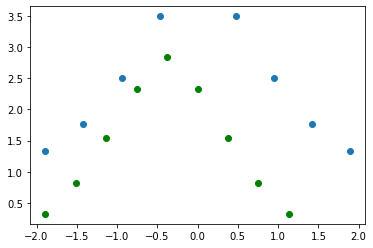

In [115]:

x = np.linspace(startR,endR,N-1)
y=[v_gauss(r)*au2ev for r in x]
plt.scatter(x, y)


x1=[startR+i*deltaX for i in range(b_1.size)]
plt.scatter(x1,sols_1*au2ev,c="green")

#try nonlinear elements


In [91]:
sols_1/y

array([0.04578669, 0.04551396, 0.04484414, 0.0412354 ,        nan,
       0.0412354 , 0.04484414, 0.04551396, 0.04578669])

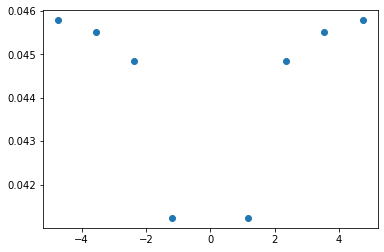

In [92]:
plt.scatter(x, sols_1/y)

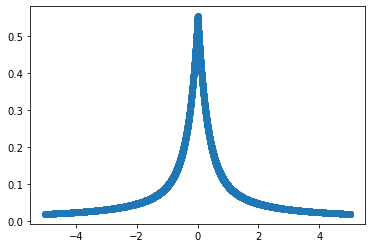

In [93]:

x = np.linspace(-5,5,10000)
y=[v(r) for r in x]
plt.scatter(x, y)

In [94]:
3/(4*np.pi*a*eps)

0.5556494767862348

In [95]:
y[np.shape(y)[0]-1]

0.018521649569791507

In [96]:
np.shape(y)[0]

10000

In [97]:
boundary_condition(startR)

0.01959960921117312

In [98]:
boundary_condition(endR)

0.01959960921117312

In [99]:
sols_1[len(sols_1)-1]

0.024419185246707185

In [100]:
scipy.special.erf(2)

0.9953222650189527

In [101]:
v_2s(endR)

-0.019791547911788287

In [102]:
b_1

array([3.76606872e-01, 3.26703440e-05, 7.59962411e-03, 6.28938519e-02,
       4.41641912e-02, 6.28938519e-02, 7.59962411e-03, 3.26703440e-05,
       3.76606872e-01])

In [103]:
d=generateUniformGrid(N)
f=generateListOfAdaptiveGridCoords(N, gaussianElectronDensity, 100, 5)
for i in range(len(d)):
    if(d[i][0] != f[i][0] or d[i][1] != f[i][1]):
        print("d", d[i])
        print("f", f[i])

In [104]:
M

NameError: name 'M' is not defined

In [ ]:
np.array_equal(M, M_1)

In [ ]:
np.array_equal(b, b_1)

In [ ]:
b

In [ ]:
b_1